# Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.signal
import fklab.signals.filter
import fklab.signals.multitaper as mt
import fklab.signals.smooth as smooth
from fklab.signals.filter import apply_high_pass_filter
from fklab.signals import filter as filt
import fklab.signals.core as sig

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
plt.style.use('seaborn-ticks')

import matplotlib.colors
import matplotlib.cm

import fklab.segments
import fklab.events
import fklab.signals.core
import fklab.signals.smooth
import fklab.statistics.circular
import fklab.spikes.simulation
import fklab.behavior.simulation



import fklab.ratemap as rm
import fklab.ratemap.utilities
import fklab.behavior.simulation
import fklab.spikes.simulation
import fklab.plot.plots
import fklab.geometry.shapes as shapes


from data_analysis import loading
from fklab.spikes.Kilosort import KiloSortResult

import seaborn as sns

from scipy.signal import decimate
import itertools

import numpy as np
import scipy
import scipy.signal

import matplotlib.pyplot as plt
%matplotlib inline

import fklab.segments
import fklab.events
import fklab.signals.core
import fklab.signals.smooth
import fklab.signals.theta
import fklab.statistics.circular
import fklab.spikes.simulation
import fklab.behavior.simulation
import fklab.ratemap

### Loading position data

In [2]:
loading.load_position('/mnt/fk-fileserver/Project_LS/LS_k_7/280720/2020-07-28_10-38-55/DLC/epochs/training/position.hdf5')
loading.load_position_yaml()
loading.load_environment_yaml()
#Dataanalysis/data_analysis

# Use the time alignment in order to get an offset value between Neuralynx and Neuropixel recording systems

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 12)

from IPython.core.display import display, HTML

# import
from fklab.signals.time_alignment import *
from fklab.io.neuralynx.nlx_sync import nlx_retrieve_event, nlx_start_recording_time
from fklab.io.spikeGLX.glx_sync import glx_extra_sync_signal

In [4]:
align_file = Path('time_offset.h5')

if align_file.exists():
    ta = TimeAlignment.load(align_file)
else:
    # load Neuralynx data
    nlx_file = Path('/mnt/fk-fileserver/Project_LS/LS_k_7/280720/2020-07-28_10-38-55/DLC/Events.nev')
    nlx_data = nlx_retrieve_event(nlx_file)

    # load Neuropixels data
    glx_file = Path('/mnt/fk-fileserver/Project_LS/LS_k_7/280720/280720_g0_imec0/280720_g0_t0.imec0.lf.bin')
    glx_data = glx_extra_sync_signal(glx_file)

    # here use another style to create a TimeAlignment instance.
    ta = TimeAlignment({
        'nlx': nlx_data,
        'npx': glx_data
    })

    # trigger time alignment, and exam whether the value make sense or not.
    print(ta.avg_time_offset('npx'))

    # save into file
    #ta.save(align_file)


ValueError: mmap length is greater than file size

In [5]:
from fklab.spikes.Kilosort.utilities_kilosort import KiloSortResult

ks = KiloSortResult('../../LS_k_8/110220/110221_g0/110221_g0_imec0/catgt_110221_g0/params.py') # load kilosort result
cluster_ids = ks.get_good_cluster_group()
spike_t = {}
for cl in ks.get_good_cluster_group():
    spike_t[cl] = ta.time_map('nlx', ks.time_sec(ks.get_spike_time(ks.get_spike_for_cluster(cl))))
    spike_t[cl] = spike_t[cl][~np.isnan(spike_t[cl])]

### load and plot position data

In [82]:
epoch = loading.position_yaml['source']['epoch']
epoch
Y_maze_epoch = [612, 2432]

In [83]:
position_time1 = np.array(loading.position_time)

nan_array = np.isnan(position_time1)
not_nan_array = ~ nan_array
position_time = position_time1[not_nan_array]

position_at = loading.position[np.logical_and(position_time> Y_maze_epoch[0],
                                     position_time < Y_maze_epoch[1]), :]
position_at_cm = position_at * 0.5



In [85]:
len(position_time)

45475

In [86]:
len(position_at)

45475

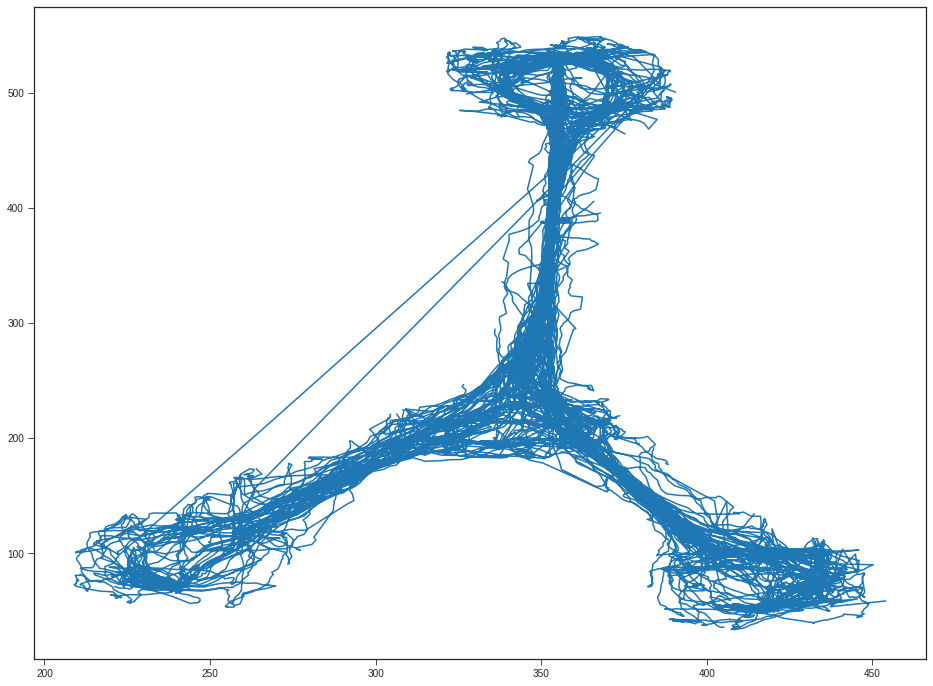

In [87]:
from fklab.behavior.preprocessing import compute_velocity
x=position_at[:,0]
y=position_at[:,1]

xy = np.column_stack([position_at])
#dt=1/25
velocity = compute_velocity(xy, dx=1.0, smooth=None)
speed = np.abs(velocity)
treshold_speed = 5
treshold_speed_fast = 10
# compute heading direction
phi = np.angle(velocity)
plt.plot(x,y)

In [88]:
from fklab.geometry.shapes import graph, polyline
Y_maze_data = loading.environment_yaml['ymaze']['shapes']['ymaze']['shape']
Y_maze_data['polylines'] = [polyline(**p) if not isinstance(p, polyline) else p for p in Y_maze_data['polylines']]
ymaze = graph(**Y_maze_data)

In [89]:
from fklab.geometry.shapes import graph, polyline, rectangle, polygon
RR = loading.environment_yaml['ymaze']['shapes']['RR']['shape']
RR = rectangle(**RR)
RR = RR.aspolygon()

LR = loading.environment_yaml['ymaze']['shapes']['LR']['shape']
LR = rectangle(**LR)
LR = LR.aspolygon()

HR = loading.environment_yaml['ymaze']['shapes']['HR']['shape']
HR = rectangle(**HR)
HR = HR.aspolygon()

CP = loading.environment_yaml['ymaze']['shapes']['CP']['shape']
CP = rectangle(**CP)
CP = CP.aspolygon()


<AxesSubplot:>

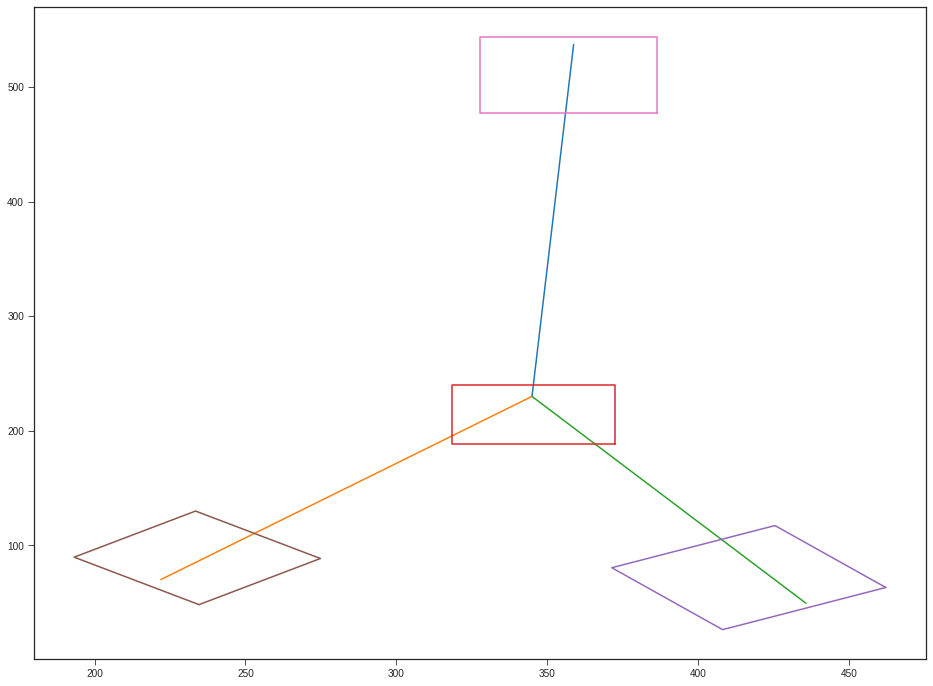

In [90]:
ymaze.plot_path()
CP.plot_path()
RR.plot_path()
LR.plot_path()
HR.plot_path()

### create segments for outbound and inbound trajectories 

In [91]:
from fklab.behavior.task_analysis import detect_trajectories

outbound_right = detect_trajectories(position_time, xy, include_regions=[HR,CP,RR], exclude_regions=[LR], ordered=True, revisit=False)
outbound_left = detect_trajectories(position_time, xy, include_regions= [HR, CP,LR], exclude_regions=[RR], ordered=True, revisit=True)
inbound_right = detect_trajectories(position_time, xy, include_regions= [RR, CP,HR], ordered=True, revisit=True)
inbound_left = detect_trajectories(position_time, xy, include_regions= [LR, CP,HR], ordered=True, revisit=True)
choice = detect_trajectories(position_time, xy, include_regions= [HR,CP], ordered=True, revisit=True)
outbound=outbound_right.union(outbound_left)
inbound=inbound_right.union(inbound_left)
right=detect_trajectories(position_time, xy, include_regions=[CP,RR], exclude_regions=[LR], ordered=True, revisit=False)
left=detect_trajectories(position_time, xy, include_regions=[CP,LR], exclude_regions=[LR], ordered=True, revisit=False)
right_in=detect_trajectories(position_time, xy, include_regions=[RR,CP], exclude_regions=[LR], ordered=True, revisit=False)
left_in=detect_trajectories(position_time, xy, include_regions=[LR,CP], exclude_regions=[RR], ordered=True, revisit=False)

In [92]:
import fklab.segments as segments
from fklab.segments import Segment
from fklab.segments.basic_algorithms import segment_intersection

treshold_speed = 5
run = Segment.fromlogical(np.abs(velocity) > treshold_speed, x=position_time, interpolate=False)

In [93]:
len(outbound)

40

In [94]:
trial=21
time_start, time_stop = outbound.start[trial], outbound.stop[trial]
out_trial = loading.position[np.logical_and(position_time> time_start,
                                     position_time < time_stop), :]


<AxesSubplot:>

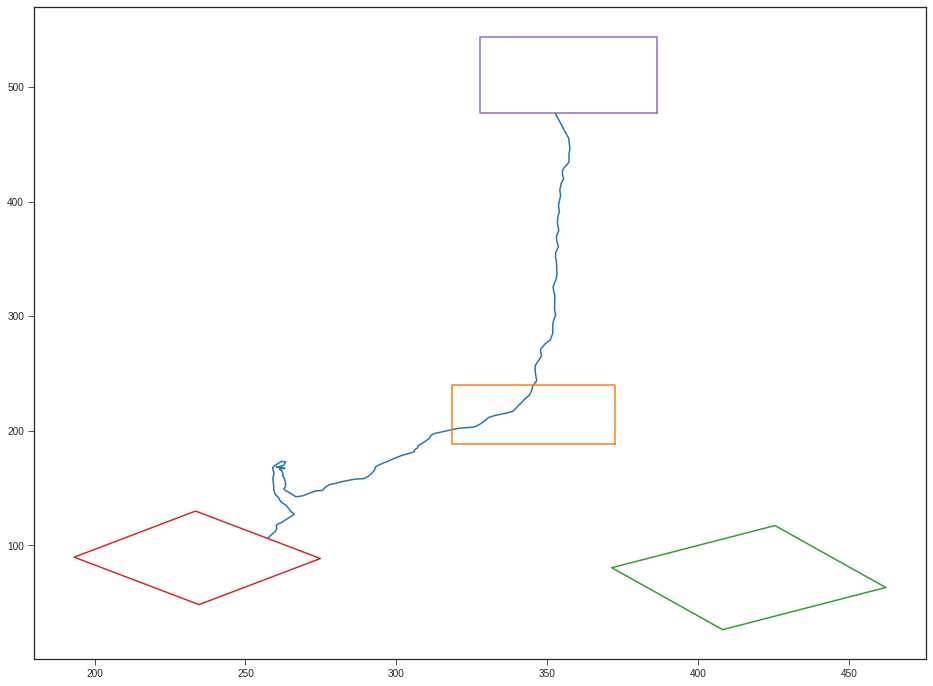

In [95]:
plt.plot(out_trial[:,0], out_trial[:,1])
CP.plot_path()
RR.plot_path()
LR.plot_path()
HR.plot_path()

In [96]:
# map into Neuropixels time
outbound_npx = ta.time_map('npx', outbound[21])
channel_number=385
# use it to fetch LFP data
lfp_data = np.memmap(glx_file, dtype=np.dtype('int16')).reshape((-1, channel_number))
#lfp_data: np.ndarray # with shape (total_steps, channel)
lfp_sample_rate = 2500 # you should get this value from meta file

lfp_outbound = []
for t1, t2 in outbound_npx:
    # map from time second to time steps
    t = slice(int(t1 * lfp_sample_rate), int(t2 * lfp_sample_rate))
    lfp_outbound.append(lfp_data[t, :])

lfp_outbound = np.vstack(lfp_outbound)

In [97]:
spike={}
spike_i=[]
for cl in ks.get_good_cluster_group():
    spike[cl] = np.logical_and(spike_t[cl] > outbound[21].start, 
                                spike_t[cl] < outbound[21].stop)
    spike_i.append(spike_t[cl][spike[cl]])

In [1]:
from scipy.interpolate import interp1d

spike_xy = interp1d(position_time, xy, axis=0, bounds_error=False, assume_sorted=True)(spike_i[2])

plt.plot(x,y, color='silver', alpha=0.6)
plt.scatter(spike_xy[:,0], spike_xy[:,1])
plt.show()

NameError: name 'position_time' is not defined

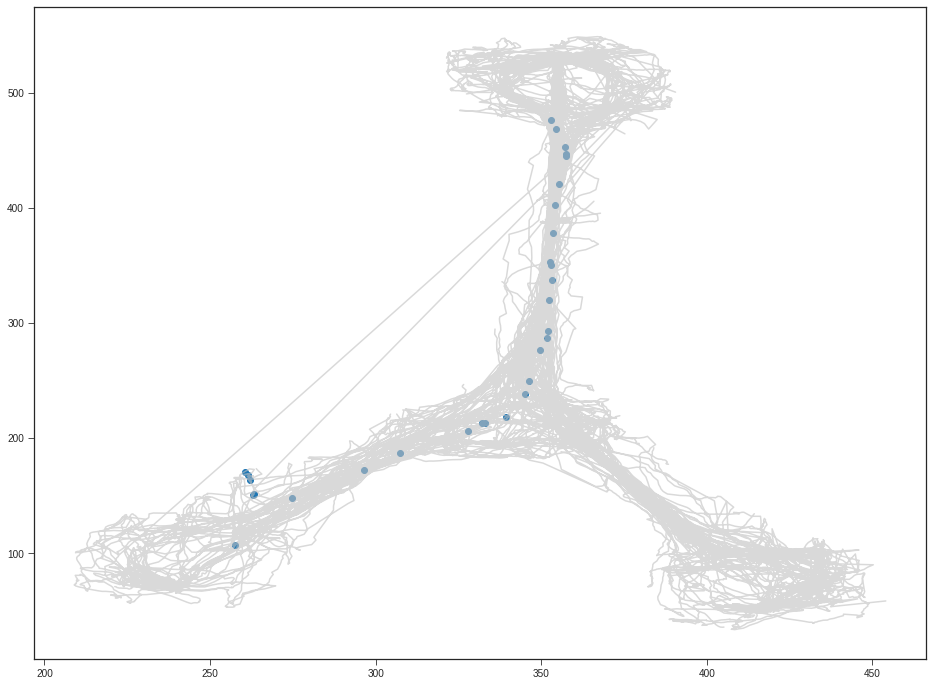

In [103]:
plt.plot(x,y, color='silver', alpha=0.6)
plt.scatter(spike_xy[:,0], spike_xy[:,1])
plt.show()

In [104]:
# map into Neuropixels time
outbound_npx = ta.time_map('npx', outbound[21])
channel_number=385
downsample_factor=5
# use it to fetch LFP data
lfp_data = np.memmap(glx_file, dtype=np.dtype('int16')).reshape((-1, channel_number))
#lfp_data: np.ndarray # with shape (total_steps, channel)
lfp_sample_rate = 2500 # you should get this value from meta file

lfp_outbound = []
lfp_outbound_t = []
for t1, t2 in outbound_npx:
    # map from time second to time steps
    s1 = int(t1 * lfp_sample_rate)
    s2 = int(t2 * lfp_sample_rate)

    lfp_outbound_t.append(np.linspace(outbound[21].start,outbound[21].stop, num=s2-s1))
    lfp_outbound.append(lfp_data[s1:s2, :])

    
lfp_outbound = np.vstack(lfp_outbound)
lfp_outbound_t = np.hstack(lfp_outbound_t)

In [105]:
from fklab.signals.filter.filter import apply_filter

theta_out = apply_filter(lfp_outbound[:,200], [6,12], fs=lfp_sample_rate)
theta_peaks = fklab.signals.core.localmaxima(y=lfp_outbound[:, 200], x=lfp_outbound_t[:, 0])

/opt/fklab-python-core/fklab/signals/filter/filter.py:210: UserWarning: This new implementation (since version 1.7) does not perform a backward filter pass like previously, which could introduce difference in the result. It should not be necessary for (symmetrical) FIR filter but if needed, you could obtained a similar effect as before by calling apply_filter twice.
  warnings.warn(
